<a href="https://colab.research.google.com/github/skyu0221/online-dropbox/blob/master/CNN_ADV_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://cdn-a.william-reed.com/var/wrbm_gb_food_pharma/storage/images/publications/feed/feednavigator.com/news/r-d/how-can-the-prenatal-phase-influence-the-lifelong-performance-of-a-pig/8769254-1-eng-GB/How-can-the-prenatal-phase-influence-the-lifelong-performance-of-a-pig_wrbm_large.jpg -O pig.jpg

--2021-07-09 00:59:42--  https://cdn-a.william-reed.com/var/wrbm_gb_food_pharma/storage/images/publications/feed/feednavigator.com/news/r-d/how-can-the-prenatal-phase-influence-the-lifelong-performance-of-a-pig/8769254-1-eng-GB/How-can-the-prenatal-phase-influence-the-lifelong-performance-of-a-pig_wrbm_large.jpg
Resolving cdn-a.william-reed.com (cdn-a.william-reed.com)... 151.101.2.49, 151.101.66.49, 151.101.130.49, ...
Connecting to cdn-a.william-reed.com (cdn-a.william-reed.com)|151.101.2.49|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 82041 (80K) [image/jpeg]
Saving to: ‘pig.jpg’

pig.jpg             100%[===================>]  80.12K  --.-KB/s    in 0.002s  

2021-07-09 00:59:42 (34.0 MB/s) - ‘pig.jpg’ saved [82041/82041]



In [2]:
from tensorflow import keras
from skimage.io import imread
from skimage.transform import resize
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, UpSampling2D, Dense, Flatten
import matplotlib.pyplot as plt
from tqdm.keras import TqdmCallback
import numpy as np

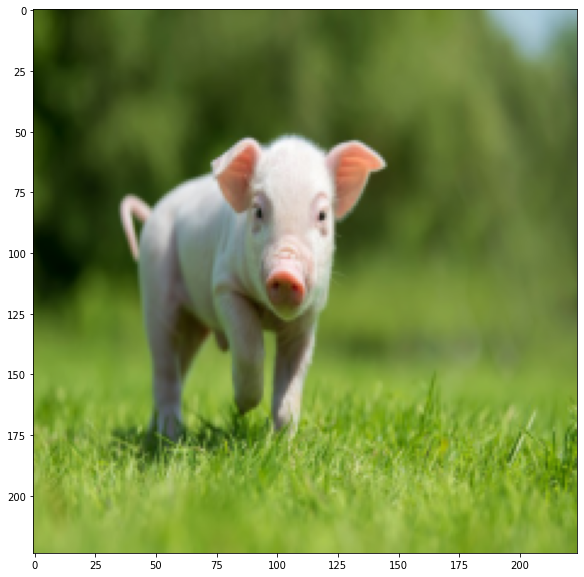

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


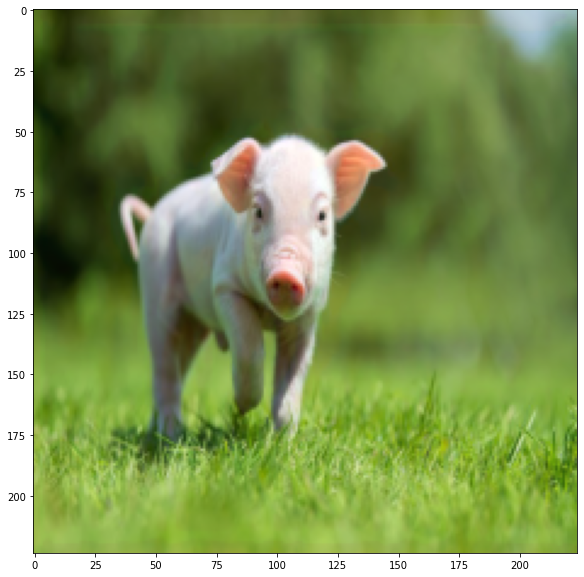

40960/35363 [==================================] - 0s 0us/step
[[('n02395406', 'hog', 0.515993), ('n02091244', 'Ibizan_hound', 0.2226465), ('n02101556', 'clumber', 0.019908238), ('n03935335', 'piggy_bank', 0.014121311), ('n02398521', 'hippopotamus', 0.011268904)]]
173
[[('n02091244', 'Ibizan_hound', 0.9745874), ('n02395406', 'hog', 0.0041424045), ('n02085620', 'Chihuahua', 0.0009218148), ('n02101388', 'Brittany_spaniel', 0.0006518636), ('n02101556', 'clumber', 0.00064980297)]]


In [3]:
mobilenet = keras.applications.MobileNetV2(
    include_top=True,
    weights="imagenet"
)

image = resize(imread("pig.jpg"), (224, 224, 3)).reshape((-1, 224, 224, 3))
plt.figure(figsize=(10, 10))
plt.imshow(image[0])
plt.show()

prediction = mobilenet.predict(image)
not_target = [1 if i != 341 else 0 for i in range(1000)]

def loss_function(prediction, y_image):
    prediction = mobilenet(image + y_image * 8 / 255)
    prediction = prediction * not_target
    loss = -keras.backend.sum(keras.backend.square(prediction), axis=1)
    return loss

model = keras.models.Sequential([
    Conv2D(32, (5, 5), input_shape=(224, 224, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(32, (5, 5), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.5),
    UpSampling2D((2, 2)),
    Conv2D(10, (3, 3), activation='sigmoid', padding='same'),
    UpSampling2D((2, 2)),
    Conv2D(3, (3, 3), activation='sigmoid', padding='same')
])



model.compile(loss=loss_function, optimizer='adam')

model.fit(image, prediction, batch_size=1, epochs=1000, verbose=0, callbacks=[TqdmCallback(verbose=0)])

adv_image = (model.predict(image) * 8 / 255) + image
plt.figure(figsize=(10, 10))
plt.imshow(adv_image[0])
plt.show()

print(keras.applications.mobilenet_v2.decode_predictions(prediction))
prediction = mobilenet.predict(adv_image)

print(np.argmax(prediction))
print(keras.applications.mobilenet_v2.decode_predictions(prediction))

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
# mean = np.array([0.4914, 0.4822, 0.4465])
# std = np.array([0.2471, 0.2435, 0.2616])

x_train = x_train.astype(float) / 255
x_test = x_test.astype(float) / 255
# for i in range(len(mean)):
#     x_train[:, :, :, i] = (x_train[:, :, :, i] / 255 - mean[i]) / std[i]
#     x_test[:, :, :, i] = (x_test[:, :, :, i] / 255 - mean[i]) / std[i]

170500096/170498071 [==============================] - 2s 0us/step


In [3]:
x_train.shape

(50000, 32, 32, 3)

In [4]:
classifier_model = keras.models.Sequential([
    Conv2D(16, (3, 3), input_shape=(32, 32, 3), activation='relu'),
    Conv2D(32, (5, 5), activation='relu'),
    Conv2D(64, (7, 7), activation='relu'),
    Flatten(),
    Dense(500, activation="relu"),
    Dense(10, activation="softmax"),
])
classifier_model.compile(loss='categorical_crossentropy',
                         optimizer='rmsprop',
                         metrics=['accuracy'])

In [5]:
classifier_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 16)        448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        12832     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 64)        100416    
_________________________________________________________________
flatten (Flatten)            (None, 25600)             0         
_________________________________________________________________
dense (Dense)                (None, 500)               12800500  
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5010      
Total params: 12,919,206
Trainable params: 12,919,206
Non-trainable params: 0
____________________________________________

In [5]:
test_y = to_categorical(y_test)
train_y = to_categorical(y_train)

In [6]:
history = classifier_model.fit(x_train, train_y,
                               batch_size=64, epochs=15,
                               callbacks=[TqdmCallback(verbose=1)], 
                               verbose=0)

KeyboardInterrupt: ignored

In [7]:
print(classifier_model.evaluate(x_test, test_y))

313/313 [==============================] - 1s 3ms/step - loss: 2.6114 - accuracy: 0.6786
[2.6113736629486084, 0.678600013256073]


In [11]:
attack_label.shape

(50000, 33, 32, 3)

In [9]:
attack_label = np.pad(x_train[:10000], ((0, 0), (0, 1), (0, 0), (0, 0)), mode='constant', constant_values=0)
for i in range(attack_label.shape[0]):
    attack_label[i, -1, y_train[i], 0] = 1

In [12]:
def loss_function(image, pertubations):
    label = image[:, -1, :10, 0]
    image = image[:, :-1, :, :]
    prediction = classifier_model(image + pertubations * 8 / 255)
    prediction = prediction * (1 - label)
    loss = -keras.backend.sum(keras.backend.abs(prediction), axis=1) * 100
    return loss

model = keras.models.Sequential([
    Conv2D(32, (5, 5), input_shape=(32, 32, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(32, (5, 5), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.5),
    UpSampling2D((2, 2)),
    Conv2D(10, (3, 3), activation='sigmoid', padding='same'),
    UpSampling2D((2, 2)),
    Conv2D(3, (3, 3), activation='sigmoid', padding='same')
])

model.compile(loss=loss_function, optimizer='rmsprop')

model.fit(x_train[:10000], attack_label, batch_size=100, epochs=1000, verbose=0, callbacks=[TqdmCallback(verbose=1)])

In [18]:
del attack_label

In [15]:
adv_x_test = (model.predict(x_test) * 8 / 255) + x_test
print(classifier_model.evaluate(adv_x_test, test_y))

313/313 [==============================] - 1s 3ms/step - loss: 3.3118 - accuracy: 0.6223
[3.3118226528167725, 0.6223000288009644]


In [16]:
adv_x_train = (model.predict(x_train) * 8 / 255) + x_train
print(classifier_model.evaluate(adv_x_train, train_y))

1563/1563 [==============================] - 5s 3ms/step - loss: 0.6903 - accuracy: 0.8549
[0.6903032064437866, 0.8548799753189087]
